In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind, ks_2samp
import os
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
import joblib

In [4]:
sns.set(style='white',palette='muted',rc={"figure.dpi":120})
RANDOM_STATE=42

In [5]:
PROCESSED_CSV = "data/processed_bank.csv"
PREPROCESSOR_PATH = "models/preprocessor.joblib"

In [6]:
df=pd.read_csv("data/bank.csv",sep=";")

In [7]:
df=pd.DataFrame(df)

In [8]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [10]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [11]:
df.duplicated().sum()

12

In [12]:
df.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

In [13]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [14]:
df.groupby("y").size()

y
no     36548
yes     4640
dtype: int64

In [15]:
cat_col=df.select_dtypes(include=['object']).columns
for col in cat_col:
    print(df[col].value_counts())

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
no         32588
unknown     8597
yes            3
Name: default, dtype: int64
yes        21576
no         18622
unknown      990
Name: housing, dtype: int64
no         33950
yes         6248
unknown      990
Name: loan, dtype: int64
cellular     26144
telephone    15044
Name: contact, dtype: int64
may    13769
jul     7174
aug     6178

In [16]:
df.columns = df.columns.str.strip()
for c in df.select_dtypes(include='object').columns:
    df[c]=df[c].str.strip()


df['y']=df['y'].astype(str).str.lower()
assert set(df['y'].unique()) <= {'yes', 'no'}, "Unexcepted y values"

TARGET VARIABLE ANALYSIS

1. Absolute Counts:


no     36548
yes     4640
Name: y, dtype: int64


2. Proportions:


no     0.8873
yes    0.1127
Name: y, dtype: float64


3. Class Imbalance Analysis:
   Majority class: no (36,548 samples)
   Minority class: yes (4,640 samples)
   Imbalance ratio: 7.88:1
    HIGHLY IMBALANCED - Consider resampling techniques


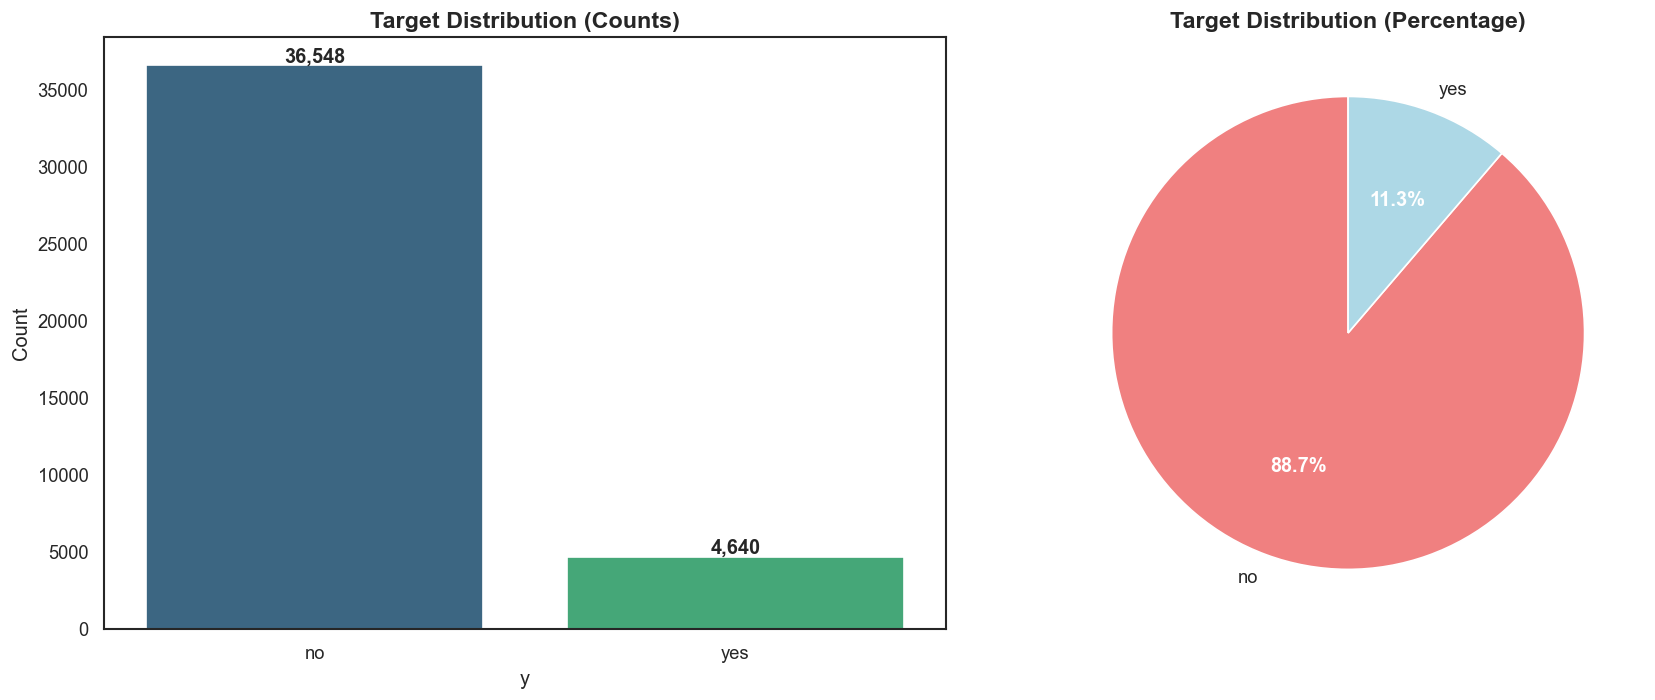

In [17]:

print("="*50)
print("TARGET VARIABLE ANALYSIS")
print("="*50)

print("\n1. Absolute Counts:")
counts = df['y'].value_counts()
display(counts)


print("\n2. Proportions:")
proportions = df['y'].value_counts(normalize=True).round(4)
display(proportions)

majority_class = counts.max()
minority_class = counts.min()
imbalance_ratio = majority_class / minority_class

print(f"\n3. Class Imbalance Analysis:")
print(f"   Majority class: {counts.index[0]} ({counts.iloc[0]:,} samples)")
print(f"   Minority class: {counts.index[1]} ({counts.iloc[1]:,} samples)")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("    HIGHLY IMBALANCED - Consider resampling techniques")
elif imbalance_ratio > 1.5:
    print("   MODERATELY IMBALANCED - Monitor model performance")
else:
    print("   WELL BALANCED")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


sns.countplot(x='y', data=df, order=['no', 'yes'], ax=ax1, palette='viridis')
ax1.set_title('Target Distribution (Counts)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count')

for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height()):,}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

colors = ['lightcoral', 'lightblue']
wedges, texts, autotexts = ax2.pie(counts.values, 
                                   labels=counts.index, 
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)
ax2.set_title('Target Distribution (Percentage)', fontsize=14, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.tight_layout()
plt.show()



In [18]:

print("="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# 1. NUMERIC FEATURES ANALYSIS
print("\n NUMERIC FEATURES ANALYSIS")
print("-" * 40)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Found {len(num_cols)} numeric columns: {num_cols}")

if num_cols:
    numeric_summary = df[num_cols].describe().T
    numeric_summary['missing'] = df[num_cols].isnull().sum()
    numeric_summary['missing_pct'] = (df[num_cols].isnull().sum() / len(df) * 100).round(2)
    
    # Reorder columns for better readability
    col_order = ['count', 'missing', 'missing_pct', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    numeric_summary = numeric_summary[col_order]
    
    display(numeric_summary)
    
    # Identify potential issues
    print("\n NUMERIC FEATURES INSIGHTS:")
    for col in num_cols:
        issues = []
        
        # Check for missing values
        missing_pct = (df[col].isnull().sum() / len(df)) * 100
        if missing_pct > 5:
            issues.append(f"{missing_pct:.1f}% missing")
        
        # Check for outliers (values beyond 3 std devs)
        if df[col].std() > 0:  # Avoid division by zero
            outliers = abs((df[col] - df[col].mean()) / df[col].std()) > 3
            outlier_pct = (outliers.sum() / len(df)) * 100
            if outlier_pct > 1:
                issues.append(f"{outlier_pct:.1f}% outliers")
        
        # Check for zero variance
        if df[col].std() == 0:
            issues.append("constant values")
        
        # Check for negative values in potentially positive-only features
        if df[col].min() < 0 and col in ['age', 'duration', 'campaign']:
            issues.append("negative values")
        
        if issues:
            print(f"    {col}: {', '.join(issues)}")
        else:
            print(f"   {col}: looks good")

# 2. CATEGORICAL FEATURES ANALYSIS
print(f"\n CATEGORICAL FEATURES ANALYSIS")
print("-" * 40)

cat_cols = df.select_dtypes(include=['object']).columns.drop('y').tolist()
print(f"Found {len(cat_cols)} categorical columns: {cat_cols}")

if cat_cols:
    for i, col in enumerate(cat_cols, 1):
        unique_vals = df[col].unique()
        unique_count = len(unique_vals)
        missing_count = df[col].isnull().sum()
        
        print(f"\n{i}. {col.upper()}")
        print(f"   Unique values: {unique_count}")
        if missing_count > 0:
            print(f"   Missing values: {missing_count}")
        
        # Show unique values (limit display for high cardinality)
        if unique_count <= 20:
            print(f"   Values: {list(unique_vals)}")
            
            # Show value counts for better understanding
            value_counts = df[col].value_counts()
            print(f"   Distribution:")
            for val, count in value_counts.head(10).items():
                pct = (count / len(df)) * 100
                print(f"     {val}: {count} ({pct:.1f}%)")
        else:
            print(f"   Values (first 10): {list(unique_vals[:10])}")
            print(f"   ... and {unique_count - 10} more")
            
            # Show top categories
            print(f"   Top 5 categories:")
            value_counts = df[col].value_counts()
            for val, count in value_counts.head(5).items():
                pct = (count / len(df)) * 100
                print(f"     {val}: {count} ({pct:.1f}%)")

# 3. FEATURE TYPE SUMMARY
print(f"\n FEATURE TYPE SUMMARY")
print("-" * 40)
print(f"Total features: {len(df.columns)}")
print(f"Numeric features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")
print(f"Target variable: 1 ('y')")

# 4. DATA QUALITY OVERVIEW
print(f"\n DATA QUALITY OVERVIEW")
print("-" * 40)
total_missing = df.isnull().sum().sum()
total_cells = df.shape[0] * df.shape[1]
missing_pct = (total_missing / total_cells) * 100

print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Total missing values: {total_missing:,} ({missing_pct:.2f}%)")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Check for duplicates
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f" Duplicate rows: {duplicates}")
else:
    print(f" No duplicate rows found")

EXPLORATORY DATA ANALYSIS

 NUMERIC FEATURES ANALYSIS
----------------------------------------
Found 10 numeric columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


,count,missing,missing_pct,mean,std,min,25%,50%,75%,max
age,41188.0,0,0.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,0,0.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,0,0.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,0,0.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0,0.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0,0.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,0,0.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,0,0.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,0,0.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,0,0.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100



 NUMERIC FEATURES INSIGHTS:
   age: looks good
    duration: 2.1% outliers
    campaign: 2.1% outliers
    pdays: 3.7% outliers
    previous: 2.6% outliers
   emp.var.rate: looks good
   cons.price.idx: looks good
   cons.conf.idx: looks good
   euribor3m: looks good
   nr.employed: looks good

 CATEGORICAL FEATURES ANALYSIS
----------------------------------------
Found 10 categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

1. JOB
   Unique values: 12
   Values: ['housemaid', 'services', 'admin.', 'blue-collar', 'technician', 'retired', 'management', 'unemployed', 'self-employed', 'unknown', 'entrepreneur', 'student']
   Distribution:
     admin.: 10422 (25.3%)
     blue-collar: 9254 (22.5%)
     technician: 6743 (16.4%)
     services: 3969 (9.6%)
     management: 2924 (7.1%)
     retired: 1720 (4.2%)
     entrepreneur: 1456 (3.5%)
     self-employed: 1421 (3.5%)
     housemaid: 1060 (2.6%)
     unemployed

 COMPREHENSIVE FEATURE VISUALIZATION

1. NUMERIC FEATURES DISTRIBUTIONS
----------------------------------------


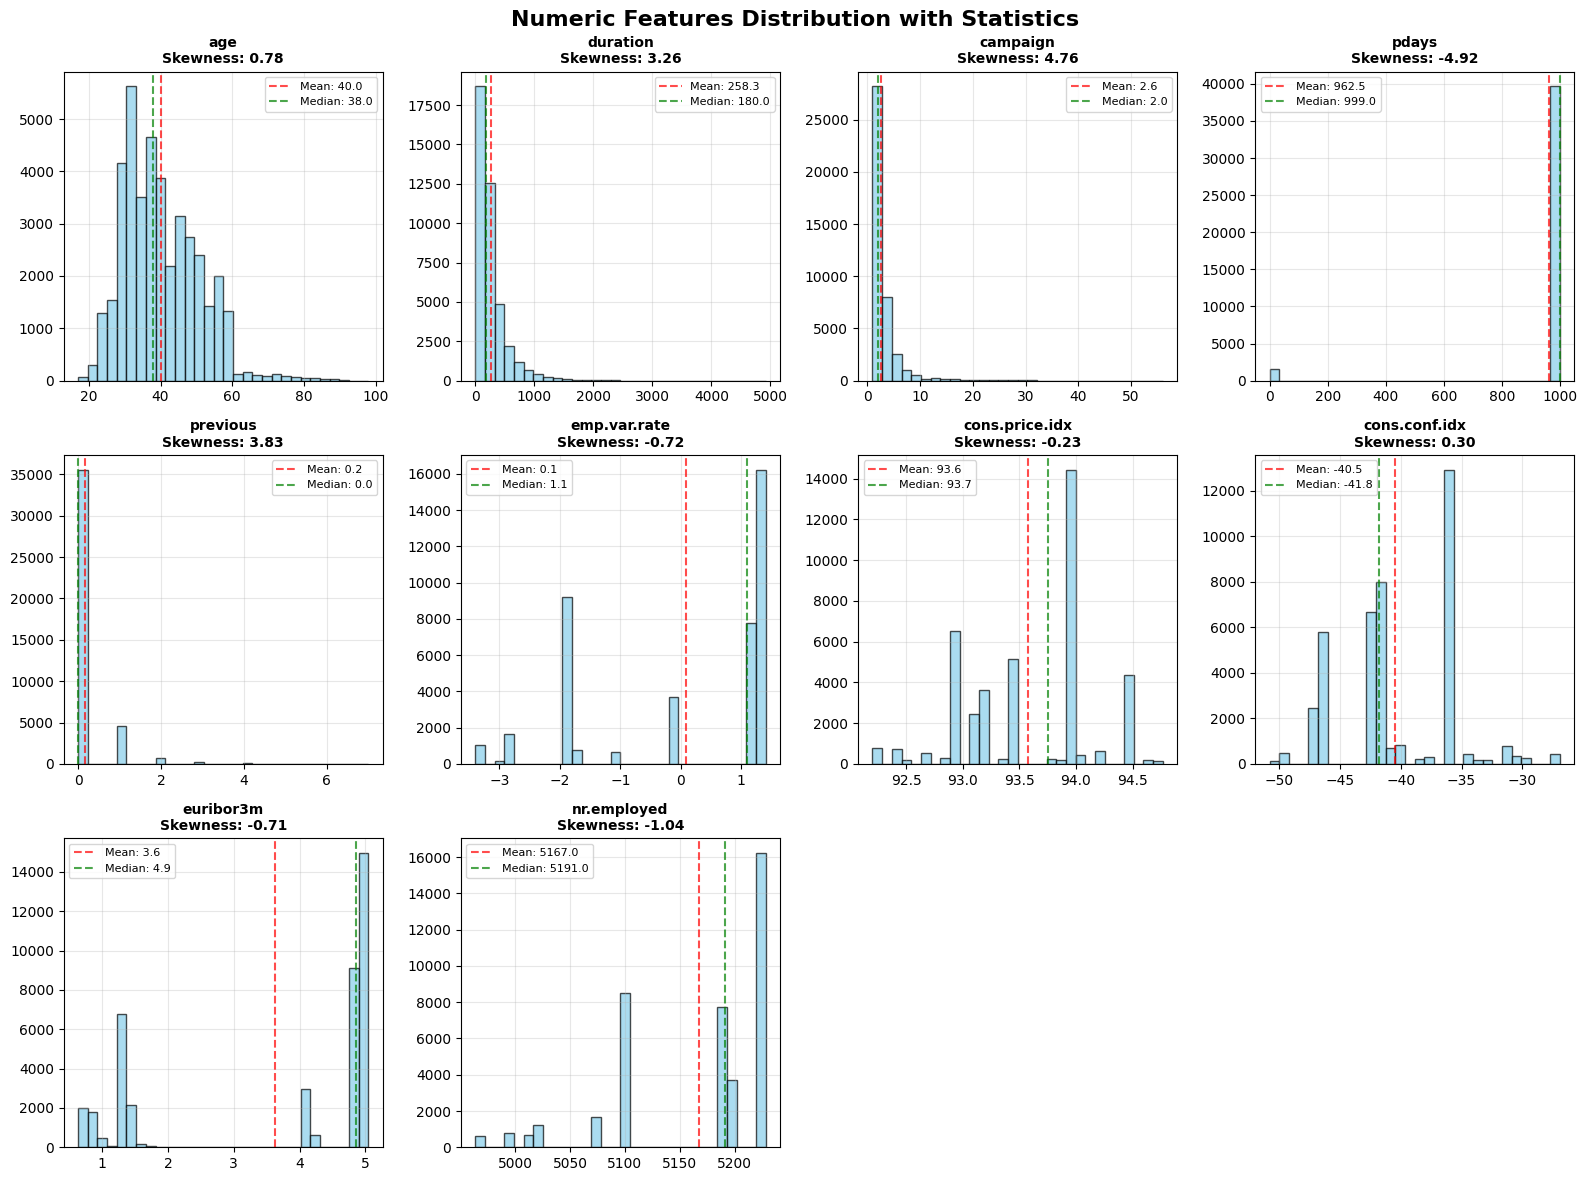


 DISTRIBUTION ANALYSIS:
   age: moderately skewed (right) - skewness: 0.78
   duration: highly skewed (right) - skewness: 3.26
   campaign: highly skewed (right) - skewness: 4.76
   pdays: highly skewed (left) - skewness: -4.92
   previous: highly skewed (right) - skewness: 3.83
   emp.var.rate: moderately skewed (left) - skewness: -0.72
   cons.price.idx: approximately normal (left) - skewness: -0.23
   cons.conf.idx: approximately normal (right) - skewness: 0.30
   euribor3m: moderately skewed (left) - skewness: -0.71
   nr.employed: highly skewed (left) - skewness: -1.04

2. CATEGORICAL FEATURES DISTRIBUTIONS
----------------------------------------


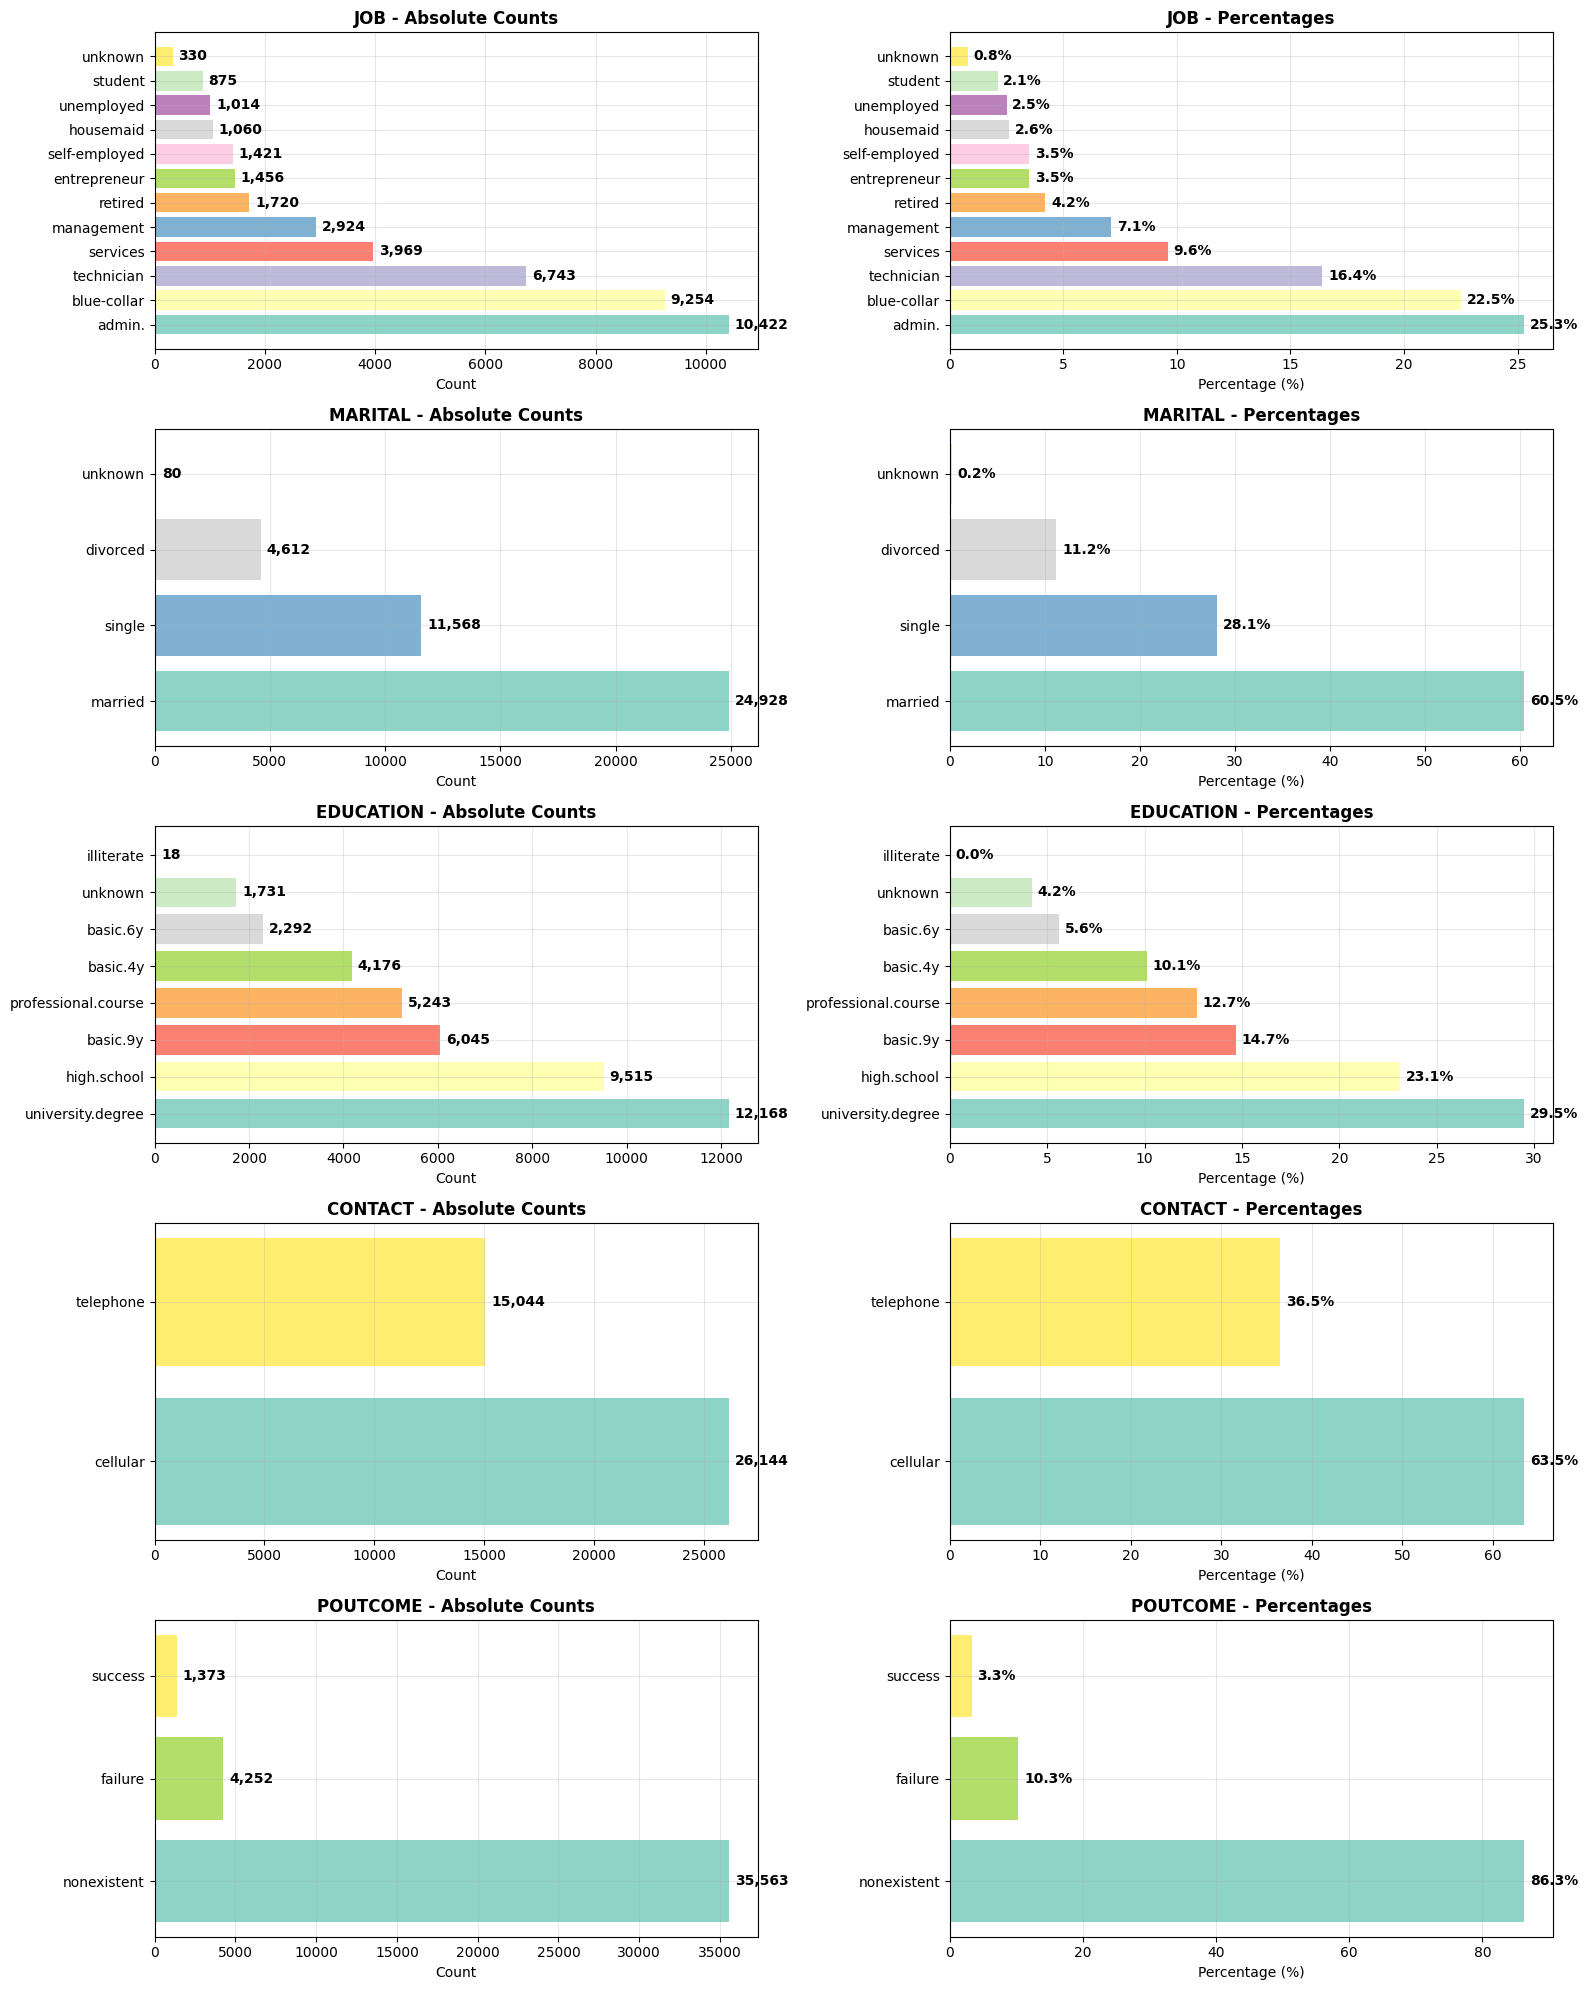


 CATEGORICAL FEATURES INSIGHTS:

   JOB:
     Categories: 12
     Most common: 'admin.' (25.3%)
      High cardinality - consider grouping or target encoding

   MARITAL:
     Categories: 4
     Most common: 'married' (60.5%)
     Well balanced distribution

   EDUCATION:
     Categories: 8
     Most common: 'university.degree' (29.5%)
     Well balanced distribution

   CONTACT:
     Categories: 2
     Most common: 'cellular' (63.5%)
     Well balanced distribution

   POUTCOME:
     Categories: 3
     Most common: 'nonexistent' (86.3%)
      Highly imbalanced - consider grouping rare categories

3. FEATURE-TARGET RELATIONSHIPS
----------------------------------------


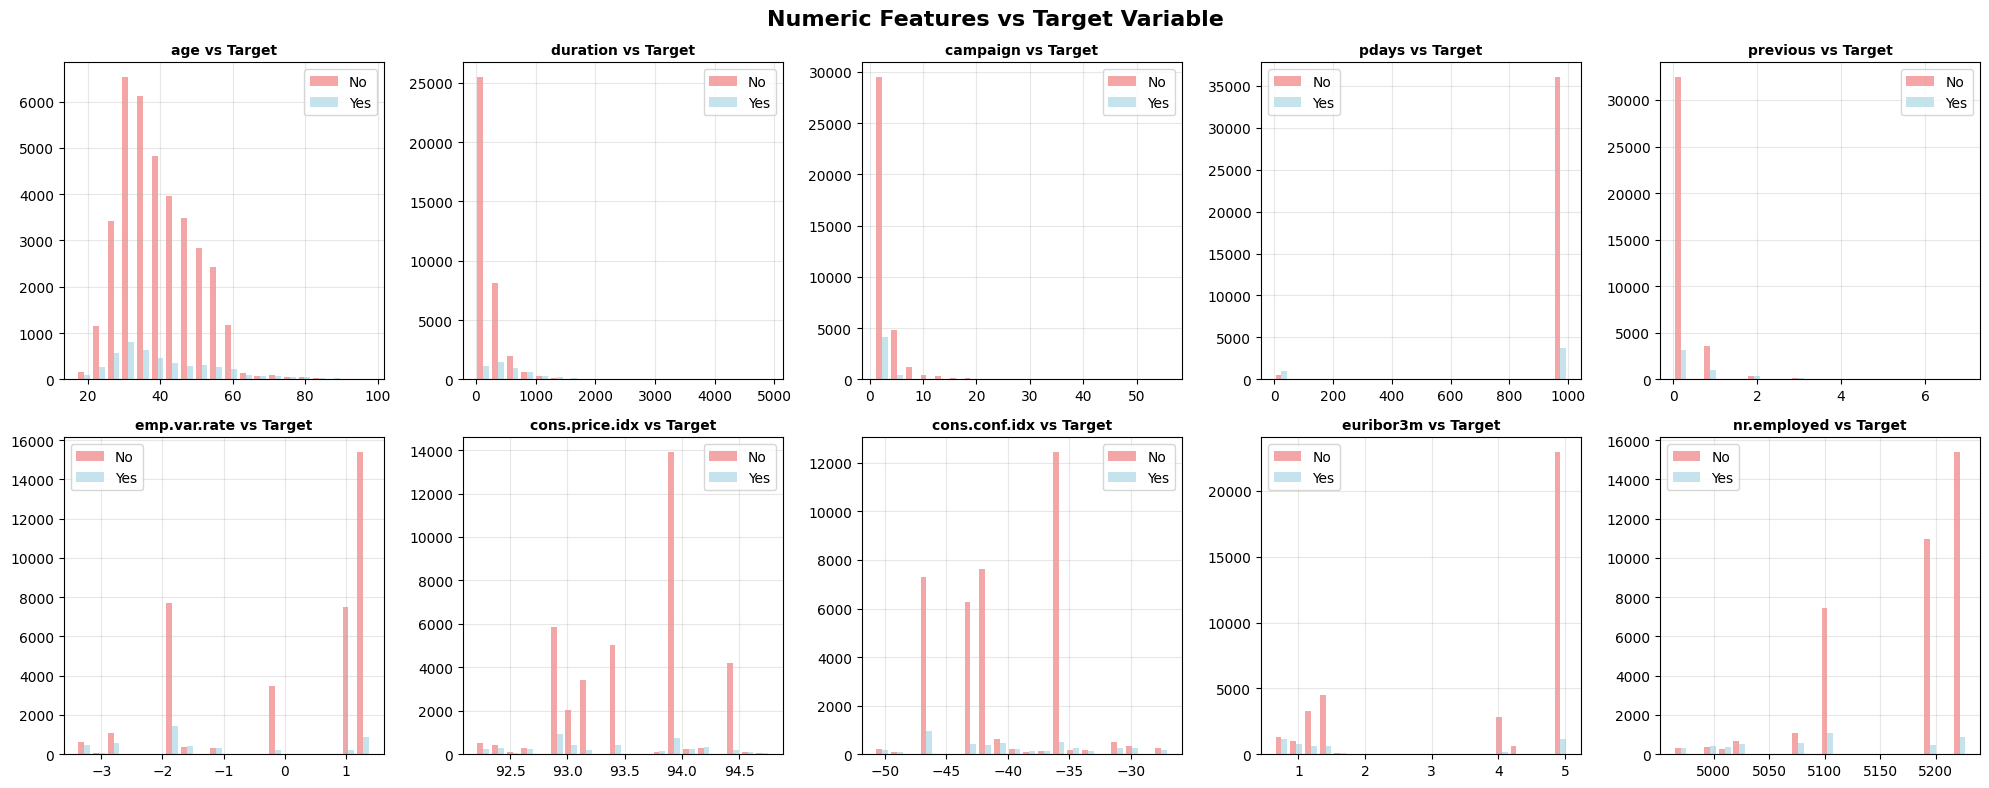

In [19]:

plt.style.use('default')
sns.set_palette("husl")

print(" COMPREHENSIVE FEATURE VISUALIZATION")
print("="*60)

print("\n1. NUMERIC FEATURES DISTRIBUTIONS")
print("-" * 40)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(num_cols):
    ax = axes[idx]
    
    
    df[col].hist(bins=30, ax=ax, alpha=0.7, color='skyblue', edgecolor='black')
    
    
    mean_val = df[col].mean()
    median_val = df[col].median()
    skew_val = stats.skew(df[col])
    
    
    ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.1f}')
    ax.axvline(median_val, color='green', linestyle='--', alpha=0.7, label=f'Median: {median_val:.1f}')
    
    ax.set_title(f'{col}\nSkewness: {skew_val:.2f}', fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)


for idx in range(len(num_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Numeric Features Distribution with Statistics', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


print("\n DISTRIBUTION ANALYSIS:")
for col in num_cols:
    skew_val = stats.skew(df[col])
    if abs(skew_val) > 1:
        skew_type = "highly skewed"
    elif abs(skew_val) > 0.5:
        skew_type = "moderately skewed"
    else:
        skew_type = "approximately normal"
    
    direction = "right" if skew_val > 0 else "left" if skew_val < 0 else "symmetric"
    print(f"   {col}: {skew_type} ({direction}) - skewness: {skew_val:.2f}")


print(f"\n2. CATEGORICAL FEATURES DISTRIBUTIONS")
print("-" * 40)

categorical_features = ['job', 'marital', 'education', 'contact', 'poutcome']


fig, axes = plt.subplots(nrows=len(categorical_features), ncols=2, figsize=(16, 20))

for idx, col in enumerate(categorical_features):
    
    ax1 = axes[idx, 0]
    vc = df[col].value_counts()
    
    
    bars = ax1.barh(range(len(vc)), vc.values, color=plt.cm.Set3(np.linspace(0, 1, len(vc))))
    ax1.set_yticks(range(len(vc)))
    ax1.set_yticklabels(vc.index)
    ax1.set_xlabel('Count')
    ax1.set_title(f'{col.upper()} - Absolute Counts', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width + max(vc.values) * 0.01, bar.get_y() + bar.get_height()/2, 
                f'{int(width):,}', ha='left', va='center', fontweight='bold')
    
    
    ax2 = axes[idx, 1]
    vc_pct = (df[col].value_counts(normalize=True) * 100).round(1)
    
    bars2 = ax2.barh(range(len(vc_pct)), vc_pct.values, color=plt.cm.Set3(np.linspace(0, 1, len(vc_pct))))
    ax2.set_yticks(range(len(vc_pct)))
    ax2.set_yticklabels(vc_pct.index)
    ax2.set_xlabel('Percentage (%)')
    ax2.set_title(f'{col.upper()} - Percentages', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
   
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        ax2.text(width + max(vc_pct.values) * 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n CATEGORICAL FEATURES INSIGHTS:")
for col in categorical_features:
    vc = df[col].value_counts()
    total_categories = len(vc)
    dominant_category = vc.index[0]
    dominant_pct = (vc.iloc[0] / len(df)) * 100
    
    print(f"\n   {col.upper()}:")
    print(f"     Categories: {total_categories}")
    print(f"     Most common: '{dominant_category}' ({dominant_pct:.1f}%)")
    
   
    if dominant_pct > 70:
        print(f"      Highly imbalanced - consider grouping rare categories")
    elif total_categories > 10:
        print(f"      High cardinality - consider grouping or target encoding")
    else:
        print(f"     Well balanced distribution")

print(f"\n3. FEATURE-TARGET RELATIONSHIPS")
print("-" * 40)


fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for idx, col in enumerate(num_cols):
    ax = axes[idx]
    
    
    df_yes = df[df['y'] == 'yes'][col]
    df_no = df[df['y'] == 'no'][col]
    
    ax.hist([df_no, df_yes], bins=20, alpha=0.7, label=['No', 'Yes'], color=['lightcoral', 'lightblue'])
    ax.set_title(f'{col} vs Target', fontsize=10, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Numeric Features vs Target Variable', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [20]:

print("\n STATISTICAL DIFFERENCES:")
for col in num_cols:
    df_yes = df[df['y'] == 'yes'][col]
    df_no = df[df['y'] == 'no'][col]
    
    # T-test for mean differences
    t_stat, p_value = ttest_ind(df_yes, df_no)
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(df_yes)-1)*df_yes.var() + (len(df_no)-1)*df_no.var()) / 
                        (len(df_yes) + len(df_no) - 2))
    cohens_d = (df_yes.mean() - df_no.mean()) / pooled_std
    
    print(f"{col}: p={p_value:.4f}, Cohen's d={cohens_d:.3f}")


 STATISTICAL DIFFERENCES:
age: p=0.0000, Cohen's d=0.096
duration: p=0.0000, Cohen's d=1.402
campaign: p=0.0000, Cohen's d=-0.210
pdays: p=0.0000, Cohen's d=-1.087
previous: p=0.0000, Cohen's d=0.748
emp.var.rate: p=0.0000, Cohen's d=-0.989
cons.price.idx: p=0.0000, Cohen's d=-0.435
cons.conf.idx: p=0.0000, Cohen's d=0.174
euribor3m: p=0.0000, Cohen's d=-1.023
nr.employed: p=0.0000, Cohen's d=-1.200


In [21]:

print(" MISSING VALUES ANALYSIS ('unknown' entries)")
print("="*50)

unknown_summary = []

for c in cat_col:
    unknown_count = (df[c]=='unknown').sum()
    if unknown_count > 0:
        total_count = len(df)
        unknown_pct = (unknown_count / total_count) * 100
        
        print(f"{c:<15} unknown count: {unknown_count:>6,} ({unknown_pct:5.1f}%)")
        
        unknown_summary.append({
            'feature': c,
            'unknown_count': unknown_count,
            'unknown_percentage': unknown_pct
        })


unknown_summary.sort(key=lambda x: x['unknown_percentage'], reverse=True)

print(f"\n PRIORITY ORDER (by % missing):")
for item in unknown_summary:
    if item['unknown_percentage'] > 50:
        status = " CRITICAL"
    elif item['unknown_percentage'] > 20:
        status = " HIGH"
    elif item['unknown_percentage'] > 5:
        status = " MEDIUM"
    else:
        status = " LOW"
    
    print(f"{status} {item['feature']}: {item['unknown_percentage']:.1f}%")

 MISSING VALUES ANALYSIS ('unknown' entries)
job             unknown count:    330 (  0.8%)
marital         unknown count:     80 (  0.2%)
education       unknown count:  1,731 (  4.2%)
default         unknown count:  8,597 ( 20.9%)
housing         unknown count:    990 (  2.4%)
loan            unknown count:    990 (  2.4%)

 PRIORITY ORDER (by % missing):
 HIGH default: 20.9%
 LOW education: 4.2%
 LOW housing: 2.4%
 LOW loan: 2.4%
 LOW job: 0.8%
 LOW marital: 0.2%


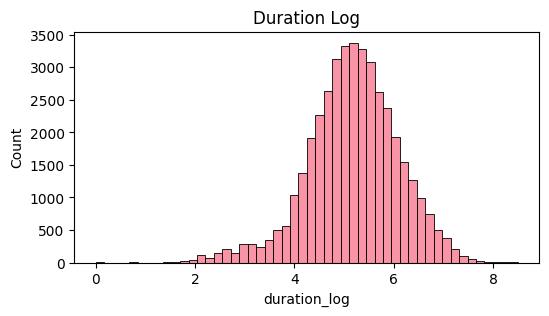

duration percentiles:


0.50     180.00
0.75     319.00
0.90     551.00
0.95     752.65
0.99    1271.13
Name: duration, dtype: float64

In [22]:
df["duration_log"]=np.log1p(df["duration"])
plt.figure(figsize=(6,3))
sns.histplot(df["duration_log"], bins=50)
plt.title('Duration Log')
plt.show()

print("duration percentiles:")
display(df['duration'].quantile([0.5,0.75,0.9,0.95,0.99]))

In [23]:
# 11. Feature engineering
df_eng = df.copy()

# pdays: create flag for never-contacted (pdays == 999)
df_eng['pdays_not_contacted'] = (df_eng['pdays'] == 999).astype(int)
df_eng['pdays_recent'] = np.where(df_eng['pdays']<999, df_eng['pdays'], np.nan)  # keep actual pdays for those contacted

# campaign buckets
df_eng['campaign_bin'] = pd.cut(df_eng['campaign'], bins=[0,1,2,4,10,100], labels=['1','2','3-4','5-10','10+'], right=False)

# interaction features
df_eng['duration_prev_interaction'] = df_eng['duration'] * (df_eng['previous'] + 1)

# cyclical encoding for month and day_of_week
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
df_eng['month_num'] = df_eng['month'].map(lambda x: month_map.get(x, np.nan))
df_eng['month_sin'] = np.sin(2*np.pi*df_eng['month_num']/12)
df_eng['month_cos'] = np.cos(2*np.pi*df_eng['month_num']/12)

dow_map = {'mon':1,'tue':2,'wed':3,'thu':4,'fri':5}
df_eng['dow_num'] = df_eng['day_of_week'].map(lambda x: dow_map.get(x, np.nan))
df_eng['dow_sin'] = np.sin(2*np.pi*df_eng['dow_num']/5)
df_eng['dow_cos'] = np.cos(2*np.pi*df_eng['dow_num']/5)

# keep duration_log from earlier
df_eng['duration_log'] = np.log1p(df_eng['duration'])

# show new features
display(df_eng[['pdays_not_contacted','pdays_recent','campaign','campaign_bin','duration_prev_interaction','duration_log']].head())


,pdays_not_contacted,pdays_recent,campaign,campaign_bin,duration_prev_interaction,duration_log
0,1,NaN,1,2,261,5.568345
1,1,NaN,1,2,149,5.010635
2,1,NaN,1,2,226,5.424950
3,1,NaN,1,2,151,5.023881
4,1,NaN,1,2,307,5.730100


In [24]:
def consolidate_rare(series, thresh=0.01, other_label='other'):
    vc = series.value_counts(normalize=True)
    mask = series.isin(vc[vc >= thresh].index)
    return series.where(mask, other_label)

for c in ['job','education']:
    df_eng[c+'_grp'] = consolidate_rare(df_eng[c], thresh=0.01)
    print(c, "unique after grouping:", df_eng[c+'_grp'].nunique())

job unique after grouping: 12
education unique after grouping: 8


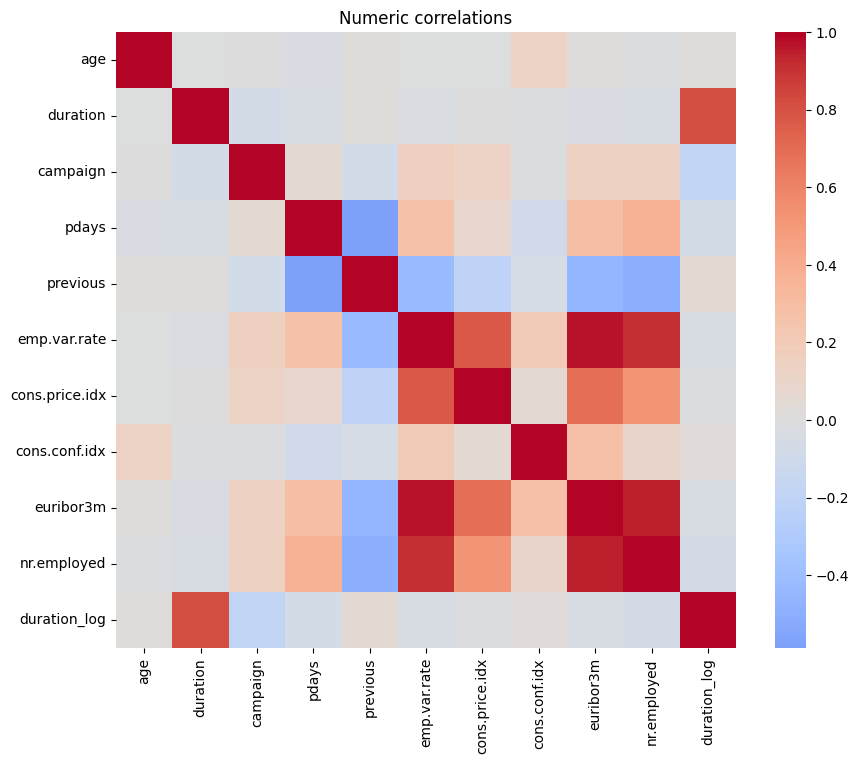

[('duration_log', 0.07622156204555752),
 ('euribor3m', 0.07513628580642018),
 ('cons.conf.idx', 0.06895861531925007),
 ('pdays_not_contacted', 0.030833719536055383),
 ('month_num', 0.026406581004977787),
 ('previous', 0.019268877762732103),
 ('age', 0.014120642590666126),
 ('campaign', 0.003334438122576158),
 ('dow_num', 0.00032199848153421917)]

In [25]:

plt.figure(figsize=(10,8))
sns.heatmap(df_eng[num_cols + ['duration_log']].corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Numeric correlations')
plt.show()


y_bin = (df_eng['y']=='yes').astype(int)
feature_candidates = ['age','duration_log','campaign','previous','pdays_not_contacted','euribor3m','cons.conf.idx','month_num','dow_num']

mi_values = {}
for c in feature_candidates:
    try:
        mi = mutual_info_classif(df_eng[[c]].fillna(0), y_bin, discrete_features=pd.api.types.is_integer_dtype(df_eng[c]) or pd.api.types.is_bool_dtype(df_eng[c]))
        mi_values[c] = mi[0]
    except Exception:
        mi_values[c] = mutual_info_classif(pd.get_dummies(df_eng[c].astype(str)), y_bin)[0]
sorted(mi_values.items(), key=lambda x: x[1], reverse=True)


In [26]:
num_features = ['age','duration_log','campaign','previous','pdays_recent',
                'euribor3m','cons.conf.idx','emp.var.rate','nr.employed']

cat_features = ['job_grp','marital','education_grp','default','housing',
                'loan','contact','poutcome','campaign_bin']

derived_features = ['pdays_not_contacted','duration_prev_interaction',
                    'month_sin','month_cos','dow_sin','dow_cos']

# Prepare data
X = df_eng[num_features + cat_features + derived_features].copy()
y = (df_eng['y'] == 'yes').astype(int)

print("X shape:", X.shape, "y shape:", y.shape)
display(X.head())

# Build preprocessing pipelines
numeric_trans = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_trans = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_trans, num_features),
    ("cat", categorical_trans, cat_features)
], remainder='passthrough')

# Fit preprocessor
preprocessor.fit(X)
print("Preprocessor fitted successfully")

# Test transformation
X_sample = X.head(3)
X_transformed = preprocessor.transform(X_sample)
print(f"Input shape: {X_sample.shape} -> Output shape: {X_transformed.shape}")

# Check data quality
print(f"NaN values: {np.isnan(X_transformed).sum()}")
print(f"Data range: [{X_transformed.min():.2f}, {X_transformed.max():.2f}]")

print("Pipeline ready for train-test split!")

X shape: (41188, 24) y shape: (41188,)


,age,duration_log,campaign,previous,pdays_recent,euribor3m,cons.conf.idx,emp.var.rate,nr.employed,job_grp,...,loan,contact,poutcome,campaign_bin,pdays_not_contacted,duration_prev_interaction,month_sin,month_cos,dow_sin,dow_cos
0,56,5.568345,1,0,NaN,4.857,-36.4,1.1,5191.0,housemaid,...,no,telephone,nonexistent,2,1,261,0.5,-0.866025,0.951057,0.309017
1,57,5.010635,1,0,NaN,4.857,-36.4,1.1,5191.0,services,...,no,telephone,nonexistent,2,1,149,0.5,-0.866025,0.951057,0.309017
2,37,5.424950,1,0,NaN,4.857,-36.4,1.1,5191.0,services,...,no,telephone,nonexistent,2,1,226,0.5,-0.866025,0.951057,0.309017
3,40,5.023881,1,0,NaN,4.857,-36.4,1.1,5191.0,admin.,...,no,telephone,nonexistent,2,1,151,0.5,-0.866025,0.951057,0.309017
4,56,5.730100,1,0,NaN,4.857,-36.4,1.1,5191.0,services,...,yes,telephone,nonexistent,2,1,307,0.5,-0.866025,0.951057,0.309017


Preprocessor fitted successfully
Input shape: (3, 24) -> Output shape: (3, 48)
NaN values: 0
Data range: [-0.87, 261.00]
Pipeline ready for train-test split!


In [27]:
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    cat_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features)
    num_names = num_features
    passthrough = derived_features
    feature_names = np.concatenate([num_names, cat_names, passthrough])

print("Total Features After Transform:", len(feature_names))
print("Feature breakdown:")
print(f"  Numeric: {len(num_features)}")
print(f"  Categorical (after encoding): {len(feature_names) - len(num_features) - len(derived_features)}")
print(f"  Derived: {len(derived_features)}")

print("\nPipeline ready for train-test split!")

Total Features After Transform: 48
Feature breakdown:
  Numeric: 9
  Categorical (after encoding): 33
  Derived: 6

Pipeline ready for train-test split!


In [28]:
print("🔧 CREATING PROPER TRAIN/TEST SPLIT")
print("="*40)

from sklearn.model_selection import train_test_split

# Use your working df_eng data
X_full = df_eng[num_features + cat_features + derived_features].copy()
y_full = (df_eng['y'] == 'yes').astype(int)

print(f"Original data check:")
print(f"Total samples: {len(y_full):,}")
print(f"Positive class: {y_full.sum():,} ({y_full.mean():.1%})")
print(f"Negative class: {(~y_full.astype(bool)).sum():,} ({(1-y_full.mean()):.1%})")

# Create proper stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full  # This ensures both classes in train AND test
)

print(f"\n✅ Proper split created:")
print(f"Train: {X_train.shape[0]:,} samples")
print(f"  - Positive: {y_train.sum():,} ({y_train.mean():.1%})")
print(f"  - Negative: {(~y_train.astype(bool)).sum():,}")

print(f"Test: {X_test.shape[0]:,} samples")  
print(f"  - Positive: {y_test.sum():,} ({y_test.mean():.1%})")
print(f"  - Negative: {(~y_test.astype(bool)).sum():,}")

# Now preprocess the properly split data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\n🚀 Ready for model training with BOTH classes!")

train_proc=X_train.copy()
train_proc['y']=y_train
test_proc=X_test.copy()
test_proc['y']=y_test

train_proc.to_csv("data/processed_train.csv", index=False)
test_proc.to_csv("data/processed_test.csv", index=False)
print("Saved processed_train.csv & processed_test.csv")
os.makedirs("models", exist_ok=True)
joblib.dump(preprocessor, PREPROCESSOR_PATH)
print("Saved preprocessor to", PREPROCESSOR_PATH)


🔧 CREATING PROPER TRAIN/TEST SPLIT
Original data check:
Total samples: 41,188
Positive class: 4,640 (11.3%)
Negative class: 36,548 (88.7%)

✅ Proper split created:
Train: 32,950 samples
  - Positive: 3,712 (11.3%)
  - Negative: 29,238
Test: 8,238 samples
  - Positive: 928 (11.3%)
  - Negative: 7,310

🚀 Ready for model training with BOTH classes!
Saved processed_train.csv & processed_test.csv
Saved preprocessor to models/preprocessor.joblib


In [29]:
print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))


Train class distribution: [29238  3712]
Test class distribution: [7310  928]


In [30]:
print("🎯 MODEL TRAINING WITH FIXED DATA")
print("="*40)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = []

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Train model
    model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC-AUC": auc
    })
    
    print(f"   Accuracy: {acc:.3f}")
    print(f"   Precision: {precision:.3f}")  
    print(f"   Recall: {recall:.3f}")
    print(f"   F1 Score: {f1:.3f}")
    print(f"   ROC-AUC: {auc:.3f}")

# Results summary
results_df = pd.DataFrame(results)
print(f"\n📊 FINAL RESULTS")
print("="*50)
display(results_df.round(3))

# Best model
best_idx = results_df['F1'].idxmax()
print(f"\n🏆 Best Model: {results_df.iloc[best_idx]['Model']}")
print(f"   F1 Score: {results_df.iloc[best_idx]['F1']:.3f}")

🎯 MODEL TRAINING WITH FIXED DATA

🔄 Training Logistic Regression...
   Accuracy: 0.848
   Precision: 0.419
   Recall: 0.899
   F1 Score: 0.571
   ROC-AUC: 0.936

🔄 Training Decision Tree...
   Accuracy: 0.895
   Precision: 0.534
   Recall: 0.497
   F1 Score: 0.515
   ROC-AUC: 0.721

🔄 Training Random Forest...
   Accuracy: 0.917
   Precision: 0.691
   Recall: 0.484
   F1 Score: 0.569
   ROC-AUC: 0.951

🔄 Training Gradient Boosting...
   Accuracy: 0.921
   Precision: 0.698
   Recall: 0.525
   F1 Score: 0.599
   ROC-AUC: 0.954

🔄 Training KNN...
   Accuracy: 0.897
   Precision: 0.561
   Recall: 0.389
   F1 Score: 0.459
   ROC-AUC: 0.867

📊 FINAL RESULTS


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.848,0.419,0.899,0.571,0.936
1,Decision Tree,0.895,0.534,0.497,0.515,0.721
2,Random Forest,0.917,0.691,0.484,0.569,0.951
3,Gradient Boosting,0.921,0.698,0.525,0.599,0.954
4,KNN,0.897,0.561,0.389,0.459,0.867



🏆 Best Model: Gradient Boosting
   F1 Score: 0.599
